# LSTM

In [1]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Keras, Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [3]:
# !pip install yfinance
# !pip install pmdarima

     |████████████████████████████████| 6.3MB 4.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=e3a8ae1aa4b56784a11e0d8e954819af005b375190a3e3779583e968b7c65e29
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 1.5MB 3.7MB/s 
     |████████████████████████████████| 9.5MB 29.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


## Goole Colab Setup

In [2]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [4]:
# Get the current working directory
print(os.getcwd())

/content


In [5]:
# Drive path is the path where I upload the ETFs history file
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move the file into the local path
local_path = '/content'

In [6]:
# Copy the file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change the file from drive path to the local path
os.chdir(local_path)

In [7]:
import util as ut

In [ ]:
def visualize_training_results(history):
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for mae
    ax1.plot(history.history['mae'])
    ax1.plot(history.history['val_mae'])
    ax1.set_ylabel('MAE')
    ax1.legend(['train', 'test'], loc='upper left')
    
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

## Preprocesing

In [8]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [9]:
vnq = data.loc[data['Ticker'] == "VNQ"]

In [10]:
# Convert Date column to datetime64 type
vnq['Date'] = pd.to_datetime(vnq['Date'])

# Set index to a datetime index
vnq.set_index('Date', inplace=True)

# Check
display(vnq.head())

print(vnq.index.inferred_type == "datetime64")

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ


True


In [11]:
train = vnq['Close'].iloc[:-253]
test = vnq['Close'].iloc[-253:]

In [12]:
# Scale the data
scaler = MinMaxScaler()

train_scale = scaler.fit_transform(train.values.reshape(-1,1))
test_scale = scaler.transform(test.values.reshape(-1,1))

In [13]:
def train_test_split (series, timestep):
    '''
    series: train or test set
    
    timestep: use n days to predict the next preceding day's price
    '''
    
    train_part, test_part = [], []
    
    for i in range(len(series)-timestep-1):
         
        train_part.append(series[i:(i+timestep)])

        test_part.append(series[i+timestep])


    return np.array(train_part), np.array(test_part)

In [25]:
X_train, y_train = train_test_split(train_scale, timestep=22)
X_test, y_test = train_test_split(test_scale, timestep=22)

In [26]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
 
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (3937, 22, 1)
y_train shape:  (3937, 1)
X_test shape:  (230, 22, 1)
y_test shape:  (230, 1)


https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM

In [27]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(LSTM(50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 22, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

3937/3937 [==============================] - 48s 11ms/step - loss: 9.4852e-04


In [ ]:
# visualize_training_results(history)

In [30]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [31]:
y_train_inv = scaler.inverse_transform(y_train_pred)
y_test_inv = scaler.inverse_transform(y_test_pred)

In [32]:
y_true = scaler.inverse_transform(y_test)

In [33]:
ut.evaluate(y_true, y_test_inv)

MAE: 1.0993
RMSE: 1.3421
R^2: 0.9730


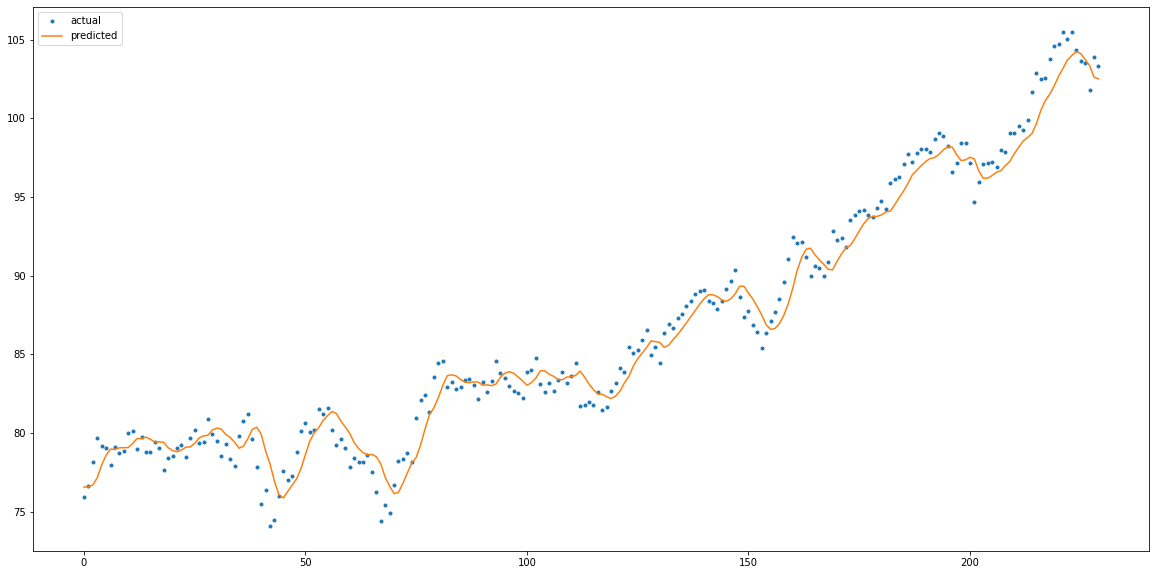

In [34]:
plt.figure(figsize=(20,10))
plt.plot(y_true, '.')
plt.plot(y_test_inv)
plt.legend(['actual', 'predicted'])
plt.show()

In [35]:
def unit_model(train_set, test_set, time_step, unit):
  X_train, y_train = train_test_split(train_set, timestep=time_step)
  X_test, y_test = train_test_split(test_set, timestep=time_step)

  model = Sequential()
  model.add(LSTM(units=unit, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(LSTM(unit))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3954/3954 [==============================] - 21s 5ms/step - loss: 0.0014


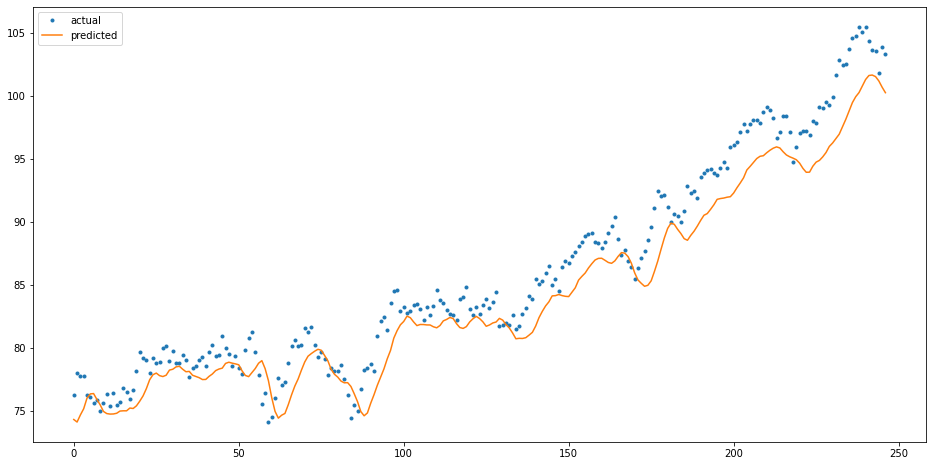

MAE: 2.1083
RMSE: 2.5022
R^2: 0.9094


In [36]:
unit_model(train_scale, test_scale, time_step=5, unit=50)

3958/3958 [==============================] - 14s 3ms/step - loss: 0.0032


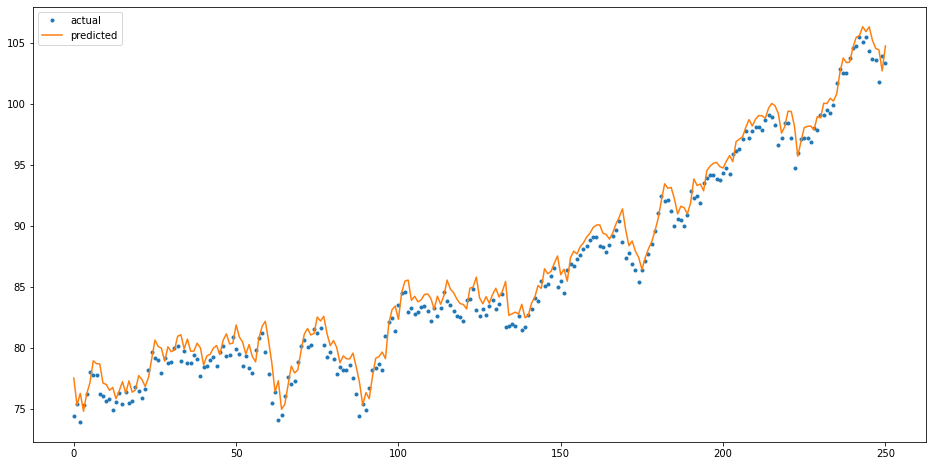

MAE: 1.0311
RMSE: 1.2788
R^2: 0.9766


In [37]:
unit_model(train_scale, test_scale, time_step=1, unit=50)

3949/3949 [==============================] - 29s 7ms/step - loss: 9.3051e-04


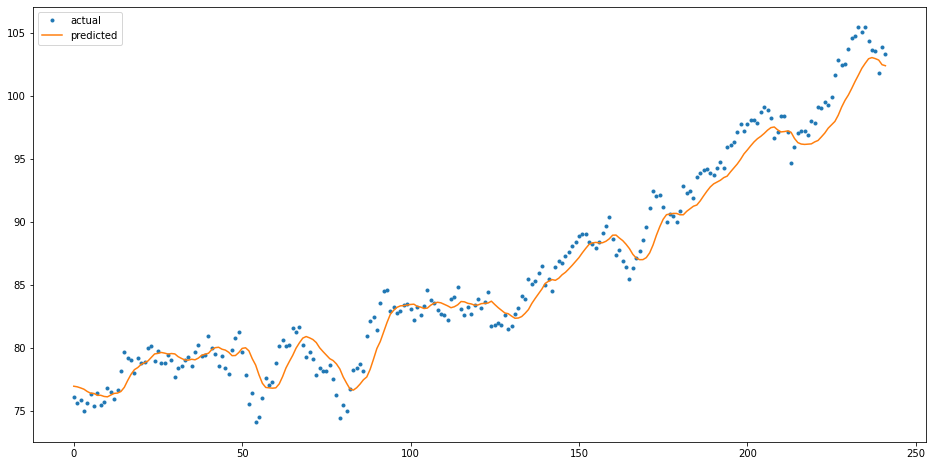

MAE: 1.3488
RMSE: 1.6874
R^2: 0.9587


In [38]:
unit_model(train_scale, test_scale, time_step=10, unit=50)

3914/3914 [==============================] - 83s 21ms/step - loss: 0.0013


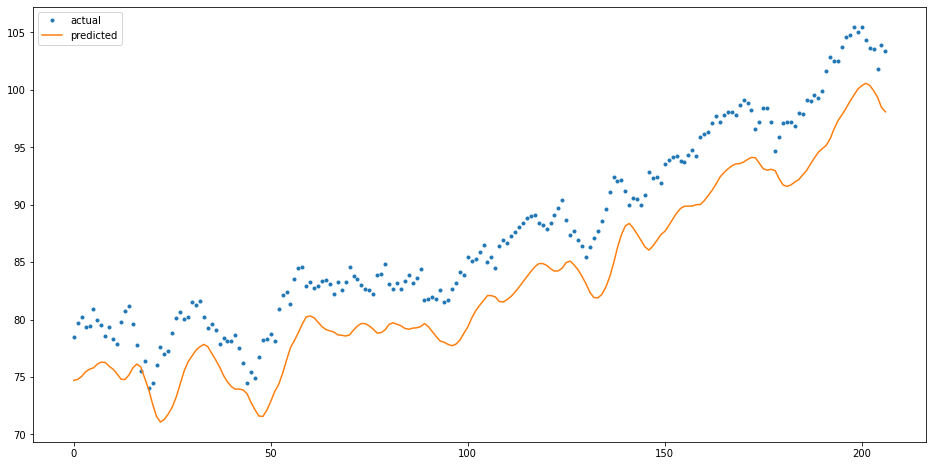

MAE: 4.4016
RMSE: 4.6159
R^2: 0.6783


In [39]:
unit_model(train_scale, test_scale, time_step=45, unit=50)

3958/3958 [==============================] - 16s 3ms/step - loss: 0.0023


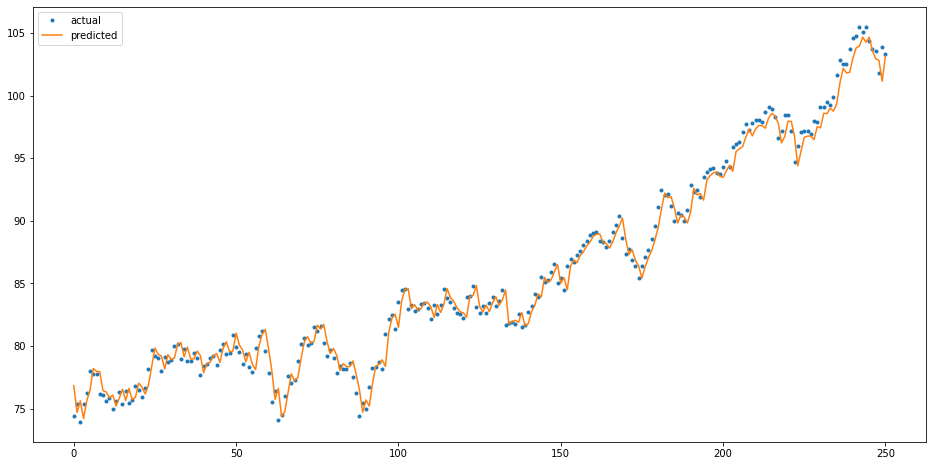

MAE: 0.8088
RMSE: 1.0025
R^2: 0.9856


In [40]:
unit_model(train_scale, test_scale, time_step=1, unit=100)

3958/3958 [==============================] - 25s 5ms/step - loss: 0.0017


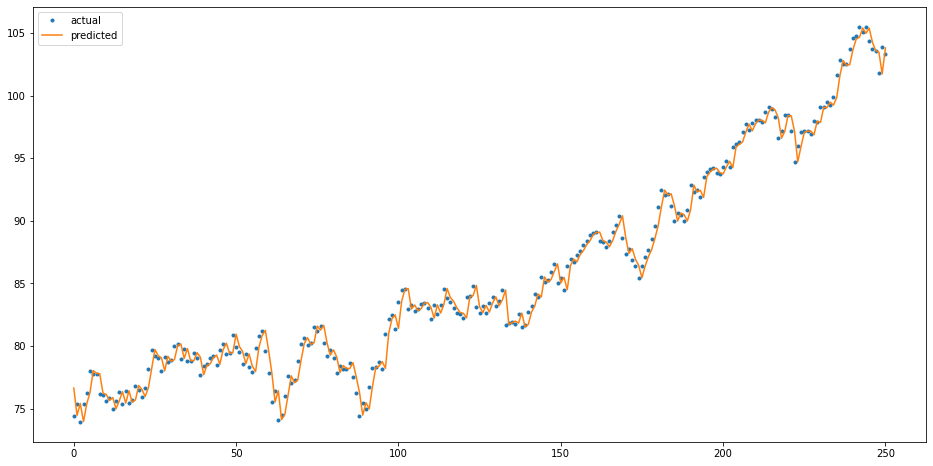

MAE: 0.7624
RMSE: 0.9537
R^2: 0.9870


In [41]:
unit_model(train_scale, test_scale, time_step=1, unit=200)

3958/3958 [==============================] - 36s 9ms/step - loss: 0.0013


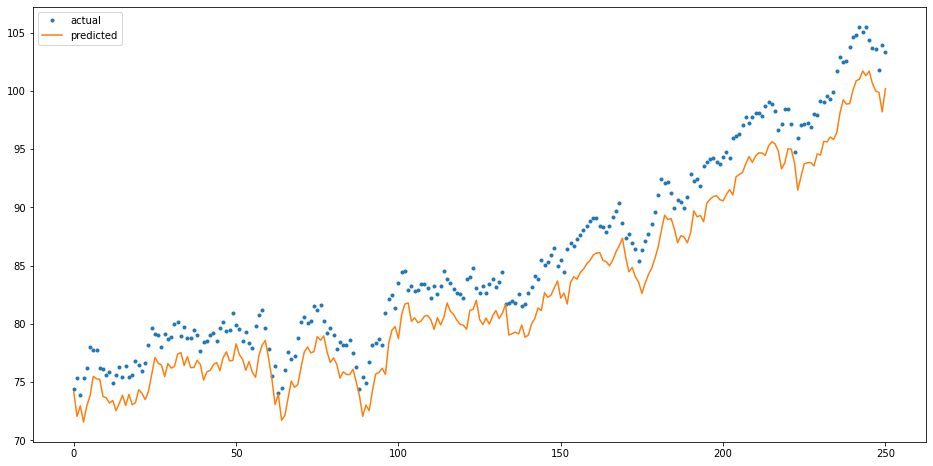

MAE: 2.9456
RMSE: 3.1174
R^2: 0.8611


In [42]:
unit_model(train_scale, test_scale, time_step=1, unit=300)

In [45]:
def dropout_model (train_set, test_set, dp):
  X_train, y_train = train_test_split(train_set, timestep=1)
  X_test, y_test = train_test_split(test_set, timestep=1)

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(Dropout(dp))
  model.add(LSTM(200))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3958/3958 [==============================] - 25s 5ms/step - loss: 0.0023


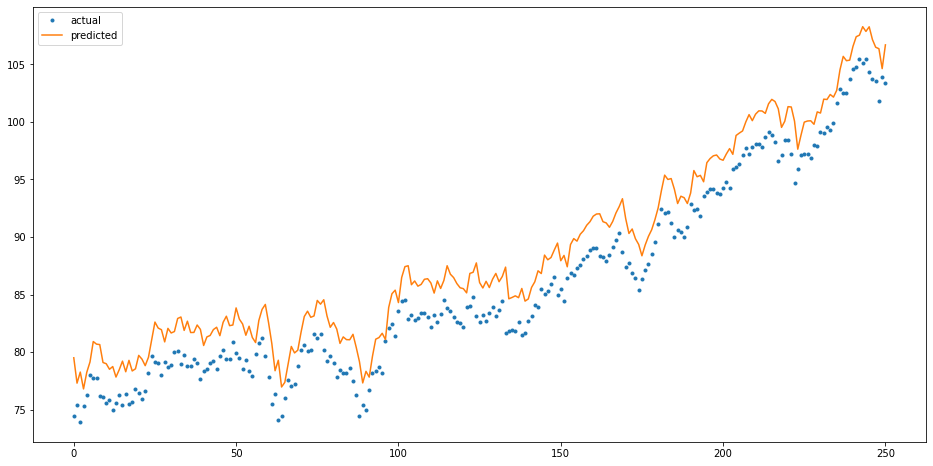

MAE: 2.8076
RMSE: 2.9639
R^2: 0.8745


In [46]:
dropout_model(train_scale, test_scale, dp=0.2)

3958/3958 [==============================] - 25s 6ms/step - loss: 0.0026


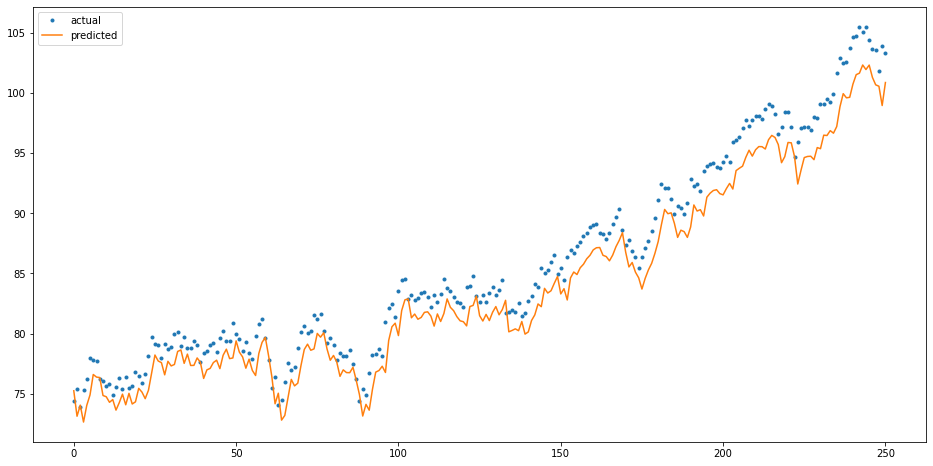

MAE: 1.9472
RMSE: 2.1858
R^2: 0.9317


In [47]:
dropout_model(train_scale, test_scale, dp=0.5)

In [48]:
def layer2_model (train_set, test_set):
  X_train, y_train = train_test_split(train_set, timestep=1)
  X_test, y_test = train_test_split(test_set, timestep=1)

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(LSTM(units=100, return_sequences=True))
  model.add(LSTM(100))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3958/3958 [==============================] - 26s 6ms/step - loss: 0.0020


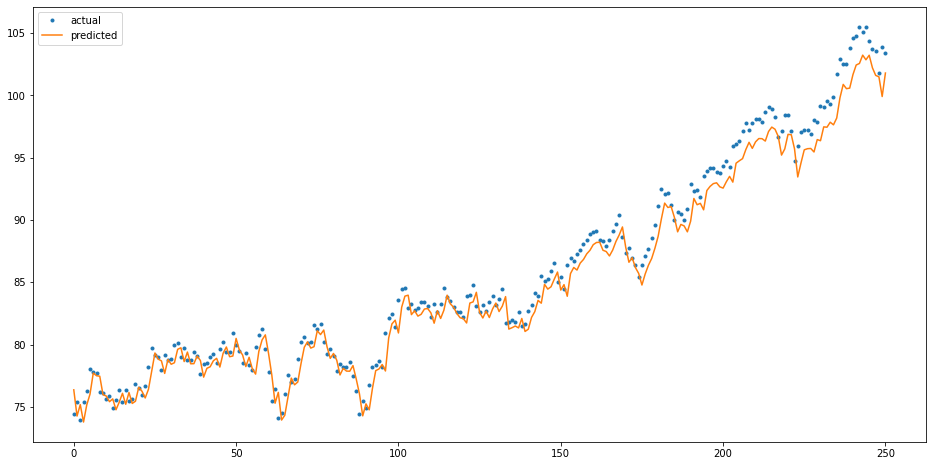

MAE: 1.1454
RMSE: 1.3835
R^2: 0.9726


In [49]:
layer2_model(train_scale, test_scale)

In [50]:
def layer3_model (train_set, test_set):
  X_train, y_train = train_test_split(train_set, timestep=1)
  X_test, y_test = train_test_split(test_set, timestep=1)

  model = Sequential()
  model.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1:])))
  model.add(LSTM(units=100, return_sequences=True))
  model.add(LSTM(units=50, return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(units=1))

  model.compile(optimizer='adam', loss='mean_squared_error')
  
  model.fit(X_train, y_train, batch_size=1, epochs=1)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  y_train_inv = scaler.inverse_transform(y_train_pred)
  y_test_inv = scaler.inverse_transform(y_test_pred)

  y_true = scaler.inverse_transform(y_test)

  plt.figure(figsize=(16,8))
  plt.plot(y_true, '.')
  plt.plot(y_test_inv)
  plt.legend(['actual', 'predicted'])
  plt.show()

  return ut.evaluate(y_true, y_test_inv)

3958/3958 [==============================] - 30s 6ms/step - loss: 0.0022


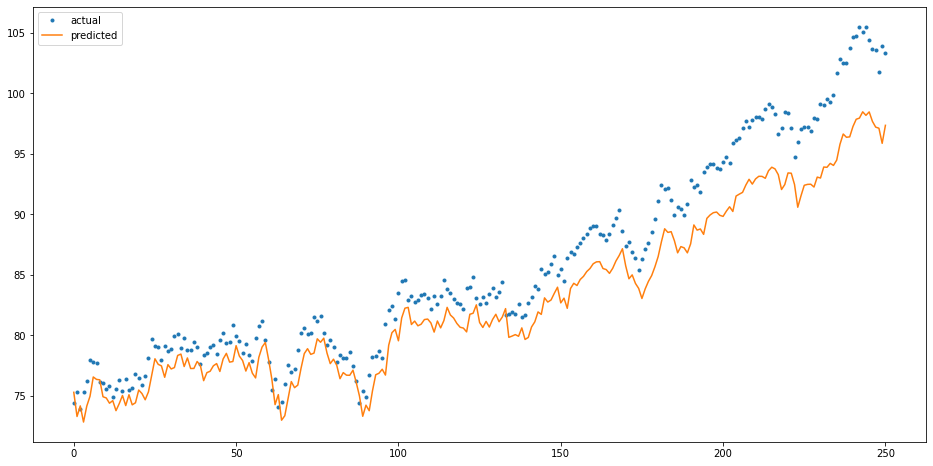

MAE: 2.8094
RMSE: 3.2994
R^2: 0.8444


In [52]:
layer3_model(train_scale, test_scale)